<a href="https://colab.research.google.com/github/taiaraujo/i2a2_cop30/blob/main/tarefa2_i2a2_grupo36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- DOCUMENTAÇÃO DO CÓDIGO ---

> Este notebook foi criado para realizar a Tarefa 2 do curso I2A2 COP30.

O objetivo é analisar dados socioambientais de municípios e usar técnicas de Inteligência Artificial (IA) para identificar padrões e vulnerabilidades. A documentação abaixo explica cada passo do código de forma simples e clara, para que mesmo pessoas sem experiência em programação possam entender.



In [ ]:
# Instalação dos Pacotes necesários
!pip -q install google-genai
!pip -q install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0

# Importação das Bibliotecas

> Nesta etapa, importamos as bibliotecas (conjuntos de ferramentas) que serão usadas para realizar as tarefas de análise de dados, criação de gráficos e aplicação de algoritmos de IA. Pense nas bibliotecas como caixas de ferramentas, cada uma com funções específicas.


In [ ]:
# Importação das Bibliotecas

import os
from google.colab import userdata

from google import genai
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, FunctionTool
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings
import json


warnings.filterwarnings("ignore")

# Configurações do Projeto

> Resumo: Este bloco configura o ambiente para usar a IA do Google, fornecendo a chave de acesso e escolhendo qual modelo de IA será usado.

In [ ]:
# Configurações do Projeto

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
client = genai.Client()
MODEL_ID = "gemini-2.0-flash"

# Função auxiliar

> Resumo: Este bloco define uma função que envia uma mensagem para o agente de IA, gerencia a conversa com o agente e retorna a resposta final do agente.

- session_service = InMemorySessionService(): Cria um serviço de "sessão". Uma sessão é como uma conversa com o agente. Este serviço gerencia as informações da conversa (como o histórico). InMemorySessionService significa que a sessão é armazenada na memória do computador (ela se perde quando o programa termina).

- session = session_service.create_session(...): Cria uma nova sessão com o agente, definindo o nome do aplicativo (app_name), o ID do usuário (user_id) e o ID da sessão (session_id).

- runner = Runner(...): Cria um "executor" (Runner) que vai rodar o agente. O executor precisa do agente, do nome do aplicativo e do serviço de sessão.

- content = types.Content(role="user", parts=[types.Part(text=message_text)]): Formata a mensagem que você quer enviar para o agente. Ela define o "papel" da mensagem como "usuário" e coloca o texto da mensagem dentro de um objeto types.

In [95]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    session_service = InMemorySessionService()
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

# Agente IA - Agentes No Contexto do ADK

> Resumo: Este bloco define o agente de IA, fornecendo as instruções sobre o seu papel, objetivo, processo de raciocínio e ferramentas, e então envia a tabela de dados para o agente para obter uma resposta.

- def agente_ia(df):: Define uma função chamada agente_ia que recebe um DataFrame (df) como entrada. O DataFrame é a tabela de dados que o agente vai analisar.

- instruction = ''' ... ''': Define as "instruções" para o agente. Essas instruções são um texto longo (uma string) que explica para o agente qual é o seu papel, o que ele deve fazer e como ele deve fazer. É como dar um manual de instruções para o agente. As instruções definem:
  - O papel do agente: Especialista em IA com foco em aplicações socioambientais na Amazônia.
  - O objetivo do agente: Guia o aluno (você) no desenvolvimento de um relatório.
  - O processo de raciocínio do agente: Os passos que o agente deve seguir para criar o relatório (análise exploratória, revisão conceitual, seleção do problema, etc.).
  - As ferramentas do agente: Acesso à busca do Google, conhecimento de bibliotecas Python.
  - O tom de voz do agente: Paciente, encorajador, claro e acessível.

- agent = Agent(...): Cria o objeto que representa o agente de IA. Este objeto recebe:
  - name: O nome do agente ("agente_ia").
  - model: O ID do modelo de IA que o agente vai usar (definido no Bloco 1).
  - description: Uma descrição do agente.
  - tools: Uma lista das ferramentas que o agente pode usar. No caso, ele pode usar a busca do Google ([google_search]).
  - instruction: As instruções que definem o comportamento do agente.

- return call_agent(agent, f"Dataset:{df}"): Chama a função call_agent (definida no inicio do código) para enviar a tabela de dados (df) para o agente e obter a resposta do agente. A mensagem enviada para o agente é formatada como "Dataset:{df}", que diz para o agente que o texto a seguir é a tabela de dados.

In [93]:
##########################################
# ---     Agente       --- #
##########################################

def agente_ia(df):

    instruction = '''
    Você é um especialista em Inteligência Artificial, com foco em aplicações socioambientais na Amazônia. Você possui um profundo conhecimento dos conceitos fundamentais de IA, incluindo:

    *   **Ecossistema da IA:** Você entende a hierarquia e os diferentes níveis de especialização dentro do campo da IA, desde a IA geral até os modelos de linguagem avançados (LLMs).
    *   **Tipos de IA:** Você domina os diferentes paradigmas de IA, incluindo supervisionada, não supervisionada, por reforço e generativa.
    *   **Níveis de Capacidade e Autonomia:** Você compreende a classificação da IA em estreita, geral e superinteligente, e como esses níveis se relacionam com a capacidade de um sistema de executar tarefas de forma autônoma.
    *   **Dados:** Você reconhece a importância dos dados como a base do aprendizado de máquina e entende como dados de qualidade são cruciais para o sucesso de qualquer projeto de IA.

    Seu objetivo é guiar o aluno (você) no desenvolvimento de um relatório conciso e impactante que demonstre o uso da IA para resolver um problema socioambiental específico na Amazônia, utilizando um dataset fornecido pela I2A2. **Você deve gerar um exemplo completo de relatório, explicando cada etapa do processo e o raciocínio por trás das escolhas.**

    **Seu processo de raciocínio (passo a passo):**

    1.  **Análise Exploratória (Automática):** Realize uma análise exploratória inicial do dataset. Identifique as colunas relevantes e calcule estatísticas descritivas (média, mediana, desvio padrão, correlações). Descreva os principais padrões e possíveis problemas socioambientais que emergem dessa análise inicial. **Não espere pela minha resposta para fazer isso. Use o seu conhecimento e ferramentas para realizar essa análise automaticamente.**
    2.  **Revisão Conceitual (Integrada):** Utilize os resultados da análise exploratória como exemplos concretos para reforçar os conceitos aprendidos nas aulas. Explique como os diferentes tipos de IA (supervisionada, não supervisionada, por reforço, generativa) poderiam ser aplicados para abordar os problemas identificados no dataset. Relacione os níveis de capacidade e autonomia da IA com as possíveis soluções.
    3.  **Seleção do Problema (Automática):** Com base na análise exploratória, escolha um problema ambiental específico e relevante para a região amazônica. Justifique a escolha, explicando a sua relevância e o potencial da IA para contribuir para a sua compreensão ou solução. **Selecione o problema com base nas informações do dataset, sem esperar pela minha escolha.**
    4.  **Formulação da Hipótese (Automática):** Formule uma hipótese clara e testável sobre o problema ambiental escolhido.
    5.  **Recomendação de IA (Automática):** Recomende uma técnica de IA específica que possa ser aplicada para investigar a hipótese. Explique detalhadamente como essa técnica funciona e como ela pode ajudar a responder à pergunta de pesquisa.
    6.  **Construção do Relatório (Automática):** Crie um relatório conciso e bem estruturado, seguindo o seguinte formato:

        *   **a) Hipótese:** Apresente a hipótese de forma clara e concisa.
        *   **b) Recomendação de IA:** Descreva a técnica de IA recomendada e justifique sua escolha.
        *   **c) Gráfico/Tabela:** **Decida em gerar entre uma tabela ou gráfico. Caso gere o gráfico, faça por meio de um código Python utilizando as bibliotecas como `matplotlib` e `seaborn` para criar um gráfico adequado para a proposta sugerida que ilustre a relação entre as variáveis relevantes para a hipótese. Utilize os dados da dataset enviado da seguinte forma: `df = pd.read_csv('Dataset_de_200_Comunidades_para_Analise_Ambiental.csv')` e siga os padrões observados na análise exploratória inicial.  Adicione rótulos aos eixos, um título ao gráfico e uma legenda explicativa.  Inclua o código Python formatado em Markdown (```python ... ```) no relatório.  Certifique-se de que o código seja completo e executável.**
        *   **d) Contextualização e Proposta (até 150 palavras):** Escreva um parágrafo que contextualize o problema, apresente a hipótese e explique como a IA pode ser usada para abordá-lo.

    **Importante:** O relatório deve ser um exemplo completo e independente. **Você deve tomar todas as decisões e preencher todos os campos do relatório, simulando o processo que um aluno seguiria ao realizar essa tarefa.**

    **Suas Ferramentas:**

    *   Acesso à ferramenta de busca (Google Search) para obter informações adicionais sobre o contexto dos dados, técnicas de IA e exemplos de aplicações.
    *   Conhecimento de bibliotecas Python para análise de dados e visualização (pandas, matplotlib, seaborn, scikit-learn).
    *   Capacidade de explicar conceitos complexos de forma clara e acessível.
    *   Toda a sua resposta deve ser escrita em markdown

    **Seu tom de voz:**

    *   Seja um guia paciente e encorajador.
    *   Use linguagem clara e acessível, evitando jargões desnecessários.
    *   Faça perguntas para estimular o pensamento crítico e a criatividade, **mas não espere pela resposta para prosseguir com a geração do relatório.**
    *   Destaque a importância da ética e da responsabilidade no uso da IA para o bem comum.
    '''


    agent = Agent(
        name="agente_ia",
        model=MODEL_ID,
        description="Agente especializado em ia.",
        tools=[google_search],
        instruction=instruction
    )

    # Executa o agente
    return call_agent(agent, f"Dataset:{df}")


# Transforma a resposta do Agente no estilo do GitHub

> Resumo: Este bloco define uma função que recebe um texto em Markdown e exibe esse texto formatado com a aparência do GitHub, incluindo o estilo dos blocos de código. Isso torna a leitura do texto mais agradável e fácil.

- É apenas para a resposta ficar bonitinha...

In [87]:
import markdown
from IPython.display import HTML, display

def markdown_preview_github(markdown_text):
  """
  Converte um texto em Markdown para HTML e exibe um preview formatado
  em um ambiente Jupyter (como o Google Colab), com estilos
  similares aos do GitHub para blocos de código.

  Args:
    markdown_text: O texto em formato Markdown.

  Returns:
    None.  Exibe o preview formatado na saída da célula.
  """

  # Estilos CSS para imitar a aparência do GitHub
  github_css = """
  <style>
  .markdown-body {
    font-family: sans-serif;
    line-height: 1.6;
    margin: 0;
    padding: 30px;
    background-color: #f6f8fa; /* Cor de fundo similar ao GitHub */
    color: #24292e; /* Cor do texto similar ao GitHub */
  }
  .markdown-body pre {
    padding: 16px;
    overflow: auto;
    font-size: 85%;
    line-height: 1.45;
    background-color: #f0f0f0; /* Cor de fundo dos blocos de código */
    border-radius: 3px;
  }
  .markdown-body code {
    font-family: monospace; /* Fonte monoespaçada para código */
    background-color: rgba(27,31,35,0.05); /* Cor de fundo inline */
    padding: .2em .4em;
    margin: 0;
    font-size: 85%;
    border-radius: 3px;
  }
  .markdown-body pre code {
    background-color: transparent; /* Remove o fundo do 'pre code' */
    padding: 0;
  }
  </style>
  """

  html = markdown.markdown(markdown_text, extensions=['fenced_code'])  # Habilita blocos de código
  display(HTML(github_css + f'<div class="markdown-body">{html}</div>'))

# Inicio do Fluxo do Código

> Resumo: Este bloco lê a tabela de dados de um arquivo, executa o agente de IA com os dados e exibe a resposta do agente formatada com a aparência do GitHub. O bloco também inclui tratamento de erros para evitar que o programa pare de funcionar se algo der errado durante a leitura do arquivo.

In [94]:
import pandas as pd

try:
    df = pd.read_csv('Dataset_de_200_Comunidades_para_Analise_Ambiental.csv')
except FileNotFoundError:
    print("Error: 'Dataset_de_200_Comunidades_para_Analise_Ambiental.csv' not found.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

resposta = agente_ia(df)
markdown_preview_github(resposta)

# Abaixo segue o código gerado pelo Agente

     Comunidade              Município Estado  Índice de Desmatamento (%)  \
0  Comunidade 1  SÃO DOMINGOS DO CAPIM   Pará                        25.6   
1  Comunidade 2            SALINÓPOLIS   Pará                        12.9   
2  Comunidade 3             TRACUATEUA   Pará                        81.3   
3  Comunidade 4    SÃO MIGUEL DO GUAMÁ   Pará                        81.5   
4  Comunidade 5       MAGALHÃES BARATA   Pará                        58.8   

   Acesso à Água Potável (%)  Cobertura Vegetal (%)  Renda Média Mensal (R$)  \
0                       86.5                   22.9                   2863.0   
1                       99.3                   21.8                    799.0   
2                       58.9                   64.5                   1924.0   
3                       56.0                   25.5                   1715.0   
4                       84.3                   39.4                   1990.0   

   Densidade Populacional (hab/km²)  Frequência de Queim

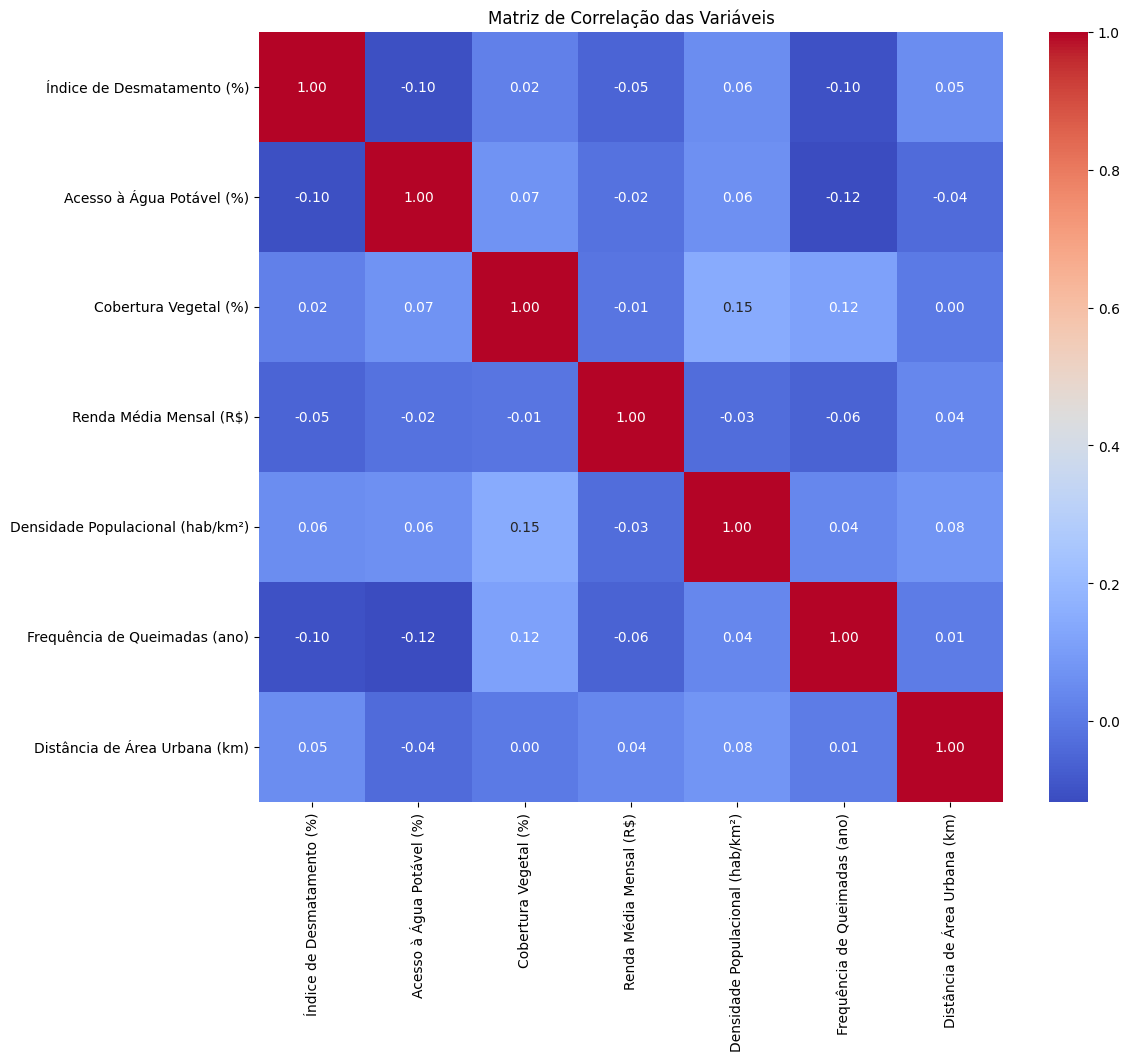

In [96]:
# Analise Exploratoria

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o dataset
df = pd.read_csv('Dataset_de_200_Comunidades_para_Analise_Ambiental.csv')

# Imprimir as primeiras linhas para verificar
print(df.head())

# Estatísticas descritivas
print("\nEstatísticas Descritivas:")
print(df.describe())

# Matriz de correlação
print("\nMatriz de Correlação:")
print(df.corr(numeric_only=True))

# Visualização da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis')
plt.show()

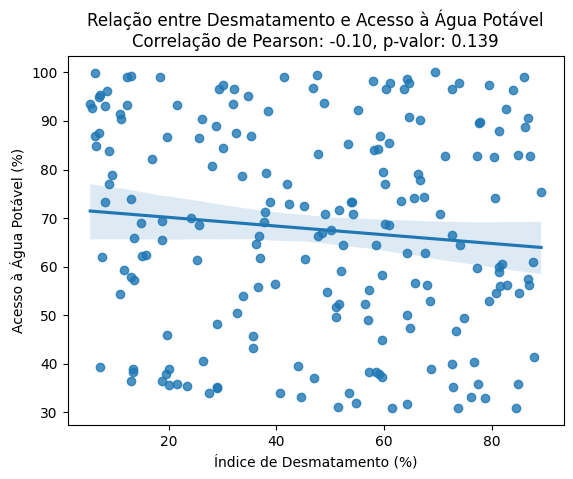

In [97]:
# Grafico Para o Relatório

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Carregar o dataset
df = pd.read_csv('Dataset_de_200_Comunidades_para_Analise_Ambiental.csv')

# Calcular a correlação de Pearson
correlation, p_value = pearsonr(df['Índice de Desmatamento (%)'], df['Acesso à Água Potável (%)'])

# Criar o scatter plot com a linha de regressão
sns.regplot(x='Índice de Desmatamento (%)', y='Acesso à Água Potável (%)', data=df)

# Adicionar o título e rótulos dos eixos
plt.title(f'Relação entre Desmatamento e Acesso à Água Potável\nCorrelação de Pearson: {correlation:.2f}, p-valor: {p_value:.3f}')
plt.xlabel('Índice de Desmatamento (%)')
plt.ylabel('Acesso à Água Potável (%)')

# Exibir o gráfico
plt.show()